Dataset: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment  
Requirements: Ensure that the Tweets.csv file is in this directory\
Question: Was this tweet retweeted atleast once?\
EDA: Please see EDA Notebook for more detailed EDA\
Instruction: Activate Environment as follows:\
$ conda activate pymc_env

In [1]:
# Confirm that the version pymc is 4 or greater
import pymc as pm
print(pm.__version__)

5.27.1


If one of the following are not installed, install using the following command: !conda install seaborn -y

In [2]:
# Imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import arviz as az # dedicated, platform-agnostic package to handle PyMC’s plotting and diagnostics functionalities
import pytensor.tensor as pt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss

In [3]:
# Load Dataset:
try:
    dataset = pd.read_csv('Tweets.csv')
    seed = 7 # reproducibility
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: The file 'Tweets.csv' was not found.")
    
except pd.errors.EmptyDataError:
    print("Error: The file 'Tweets.csv' is empty.")
    
except pd.errors.ParserError:
    print("Error: Could not parse the CSV file. It might be corrupted.")
    
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Dataset loaded successfully!


In [4]:
# Very Basic EDA:
print(f"Dataset Shape: {dataset.shape}")
print(f"\nNumber of Features in Train: {dataset.shape[1]}")
print("\n" + "=" * 60)
dataset.info()
print("\n" + "=" * 60)
missing = dataset.isnull().sum()
missing_pct = (missing / len(dataset)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Percentage': missing_pct.values
    }).query('Missing_Count > 0').sort_values('Percentage', ascending=False)   
print("\nMissing Values:")
if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
print("\n" + "=" * 60)

print("Full row duplicates:", dataset.duplicated().sum())
print("Duplicate tweet_id:", dataset['tweet_id'].duplicated().sum())
print("Duplicate text:", dataset['text'].duplicated().sum())


Dataset Shape: (14640, 15)

Number of Features in Train: 15

<class 'pandas.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  str    
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   str    
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  str    
 6   airline_sentiment_gold        40 non-null     str    
 7   name                          14640 non-null  str    
 8   negativereason_gold           32 non-null     str    
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  str    
 11  tweet_coord                   1019 non-null   str    
 12  tweet_crea

In [5]:
# Drop full row duplicates, keep first occurence
dataset = dataset.drop_duplicates(keep="first")

# Keep the row with the most information for duplicate tweet id's
dataset["_non_nulls"] = dataset.notna().sum(axis=1)
dataset = (dataset.sort_values(["tweet_id", "_non_nulls"], ascending=[True, False])
                    .drop_duplicates(subset=["tweet_id"], keep="first")
                    .drop(columns=["_non_nulls"]))

print("Full row duplicates:", dataset.duplicated().sum())
print("Duplicate tweet_id:", dataset['tweet_id'].duplicated().sum())
print("Duplicate text:", dataset['text'].duplicated().sum())
print(f"Dataset Shape: {dataset.shape}")


Full row duplicates: 0
Duplicate tweet_id: 0
Duplicate text: 58
Dataset Shape: (14485, 15)


Keeping the duplicate text as it might be important for retweet probability, identitical texts might have different retweet ooutcomes. 

In [6]:
# Target Distribution
dataset["y_retweeted"] = (dataset["retweet_count"] >= 1).astype(int)
print(dataset["y_retweeted"].value_counts())

print("\n" + "=" * 60)

# Basic Summary per Airline
airline_stats = (dataset.groupby("airline").agg(
          total_retweets=("retweet_count", "sum"),
          mean_retweets=("retweet_count", "mean"),
          tweet_count=("retweet_count", "count"),
          retweet_rate=("y_retweeted", "mean")).sort_values("retweet_rate", ascending=False))

print(airline_stats)

print("\n" + "=" * 60)

# Total Retweet Counts per Sentiment
retweets_by_sentiment = (dataset.groupby("airline_sentiment")["retweet_count"].sum().sort_values(ascending=False))

# Total Retweet Counts per Negative Reason
retweets_by_reason = (dataset[dataset["airline_sentiment"] == "negative"].groupby("negativereason")["retweet_count"].sum().sort_values(ascending=False))

print("How many total retweets were generated by tweets of each sentiment?\n", retweets_by_sentiment)
print("\n" + "=" * 60)
print("Of the negative sentiment, which reasons were retweeted?\n", retweets_by_reason)

y_retweeted
0    13720
1      765
Name: count, dtype: int64

                total_retweets  mean_retweets  tweet_count  retweet_rate
airline                                                                 
United                     421       0.110152         3822      0.099163
Delta                      252       0.113411         2222      0.041404
US Airways                 249       0.085479         2913      0.040851
Southwest                  145       0.059917         2420      0.035537
Virgin America              26       0.051587          504      0.029762
American                   115       0.044163         2604      0.028418

How many total retweets were generated by tweets of each sentiment?
 airline_sentiment
negative    855
neutral     189
positive    164
Name: retweet_count, dtype: int64

Of the negative sentiment, which reasons were retweeted?
 negativereason
Customer Service Issue         220
Can't Tell                     219
Late Flight                    155
Cancel

Dataset is imbalanced with this target, retweet event is rare. Keep this in mind for metric evaluation.
Target: 1: retweeted by any number of times greater than 1. 0 if not retweeted.

In [7]:
Train = dataset.copy()
Train["text_len"] = Train["text"].astype(str).str.len()
Train["tweet_created_dt"] = pd.to_datetime(Train["tweet_created"], errors="coerce")
Train["hour"] = Train["tweet_created_dt"].dt.hour

Train["hour_sin"] = np.sin(2 * np.pi * Train["hour"] / 24) # Cyclical encoding
Train["hour_cos"] = np.cos(2 * np.pi * Train["hour"] / 24) 

# Select features to use
feature_cols = [
    "airline_sentiment_confidence",
    "airline",
    "text_len",
    "airline_sentiment",
    "hour_sin",
    "hour_cos",
]
num_cols = ["airline_sentiment_confidence", "text_len", "hour_sin", "hour_cos",]

Train_raw = Train[feature_cols].copy()

# One-hot encode categoricals
X = pd.get_dummies(Train_raw, columns=["airline", "airline_sentiment"], drop_first=True)

# Convert booleans to ints if any appear
for c in X.columns:
    if X[c].dtype == bool:
        X[c] = X[c].astype(int)

y = Train["y_retweeted"].astype(int)

# Split train and test so we can evaluate, use stratify for target imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

# Standardize numeric columns using train stats
means = X_train[num_cols].mean()
stds = X_train[num_cols].std().replace(0, 1)

X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_std[num_cols] = (X_train_std[num_cols] - means) / stds
X_test_std[num_cols] = (X_test_std[num_cols] - means) / stds

N, D = X_train_std.shape

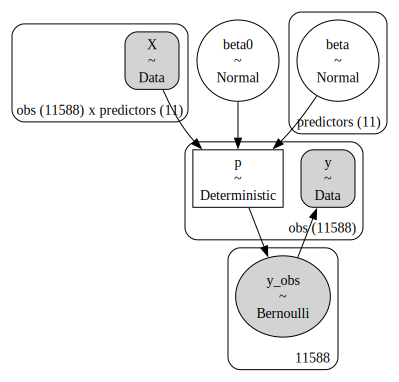

In [8]:
coords = {"predictors": X_train_std.columns.values}

with pm.Model(coords=coords) as retweet_model:
    # Data containers so we can swap train/test later
    X_data = pm.Data("X", X_train_std.values, dims=("obs", "predictors"))
    y_data = pm.Data("y", y_train.values, dims=("obs",))

    # Compute log-odds of base rate
    base_rate = y_train.mean()
    logit_base = np.log(base_rate / (1 - base_rate))

    # Prior on (logit) intercept: 
    beta0 = pm.Normal("beta0", mu=logit_base, sigma=1.0)
    beta = pm.Normal("beta", mu=0.0, sigma=1.0, dims="predictors")

    # Linear predictor (log-odds) for each observation
    eta = beta0 + pt.dot(X_data, beta)
    # Converts log-odds (eta) into probabilities, its deterministic as it is derived
    p = pm.Deterministic("p", pm.math.sigmoid(eta), dims="obs")

    # Likelihood - ensures probabilities remain in [0,1] because retweet occurrence is binary
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_data)

pm.model_to_graphviz(retweet_model)

Sampling: [beta, beta0, y_obs]
C:\ProgramData\miniconda3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 106 seconds.


Observed train positive rate: 0.052813255091473936
Simulated prior positive rate: 0.17683586468760784


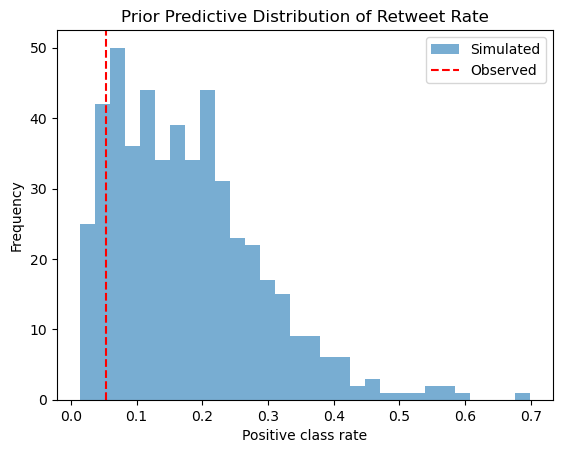

In [9]:
# PyMC is drawing samples from the posterior distribution using NUTS (No-U-Turn Sampler).

with retweet_model:
    prior = pm.sample_prior_predictive(samples=500, random_seed=seed)
    idata = pm.sample(1000, tune=2000, random_seed=seed, target_accept=0.95) 
    # 1000 posterior samples per Markov chain (default is 4), the tune should be twice the number of draws. 
obs_rate = y_train.mean()

# Extract numpy array 
y_prior = prior.prior_predictive["y_obs"].values
y_prior_flat = y_prior.reshape(-1, y_prior.shape[-1])   # (samples, obs)

# Positive rate per prior draw
prior_rates = y_prior_flat.mean(axis=1)

sim_rate = prior_rates.mean()

print("Observed train positive rate:", obs_rate)
print("Simulated prior positive rate:", sim_rate)

plt.hist(prior_rates, bins=30, alpha=0.6, label="Simulated")
plt.axvline(obs_rate, color="red", linestyle="--", label="Observed")
plt.xlabel("Positive class rate")
plt.ylabel("Frequency")
plt.legend()
plt.title("Prior Predictive Distribution of Retweet Rate")
plt.show()

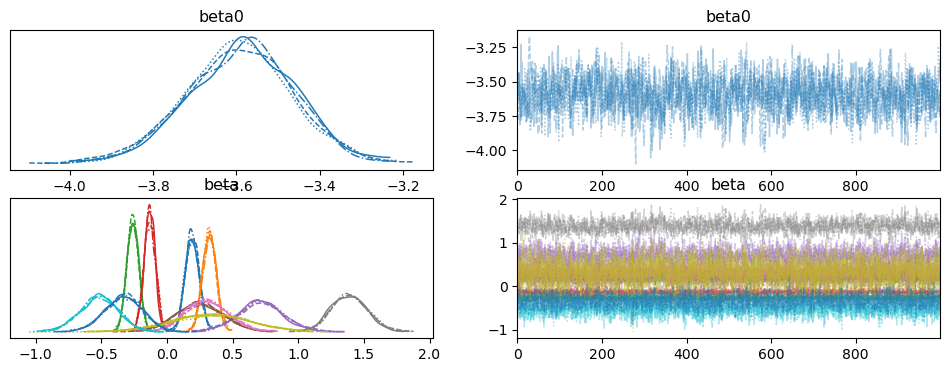

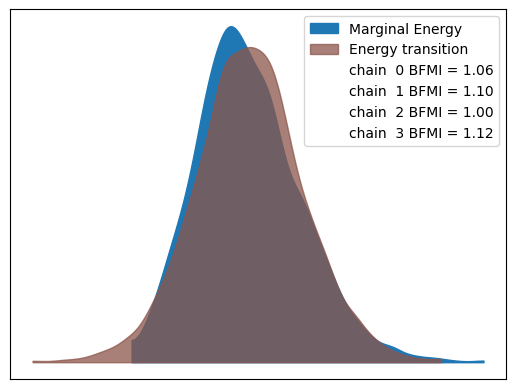

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-3.592,0.128,-3.817,-3.336,0.004,0.002,1154.0,1933.0,1.0
beta[airline_sentiment_confidence],0.192,0.052,0.096,0.287,0.001,0.001,4122.0,3334.0,1.0
beta[text_len],0.324,0.051,0.228,0.420,0.001,0.001,4646.0,2733.0,1.0
beta[hour_sin],-0.260,0.044,-0.343,-0.176,0.001,0.001,5632.0,3017.0,1.0
beta[hour_cos],-0.131,0.043,-0.217,-0.054,0.001,0.001,5276.0,3183.0,1.0
beta[airline_Delta],0.713,0.172,0.394,1.052,0.004,0.003,1590.0,2523.0,1.0
beta[airline_Southwest],0.249,0.178,-0.084,0.578,0.005,0.003,1480.0,2690.0,1.0
beta[airline_US Airways],0.307,0.161,0.000,0.604,0.004,0.002,1528.0,2062.0,1.0
beta[airline_United],1.390,0.136,1.144,1.652,0.004,0.002,1205.0,2109.0,1.0
beta[airline_Virgin America],0.326,0.293,-0.220,0.867,0.005,0.004,3558.0,2858.0,1.0


In [10]:
az.plot_trace(idata, var_names=["beta0", "beta"])
plt.show()

az.plot_energy(idata)
plt.show()

az.summary(idata, var_names=["beta0", "beta"])


predictors
airline_sentiment_confidence    0.192195
text_len                        0.323521
hour_sin                       -0.260467
hour_cos                       -0.131404
airline_Delta                   0.713284
airline_Southwest               0.249261
airline_US Airways              0.306837
airline_United                  1.390197
airline_Virgin America          0.325778
airline_sentiment_neutral      -0.517973
airline_sentiment_positive     -0.329515
Name: beta, dtype: float64
['airline_United', 'airline_Delta', 'airline_sentiment_neutral', 'airline_sentiment_positive', 'airline_Virgin America', 'text_len', 'airline_US Airways', 'hour_sin', 'airline_Southwest', 'airline_sentiment_confidence', 'hour_cos']


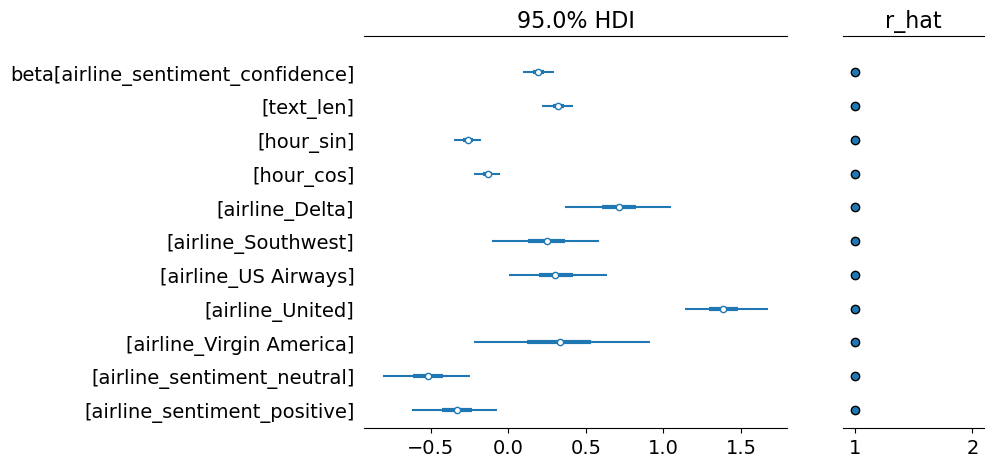

In [11]:
# Get posterior means of beta to pick top absolute effects
beta_post = idata.posterior["beta"].mean(("chain", "draw")).to_series()
top = beta_post.abs().sort_values(ascending=False).head(20).index.tolist()
print(beta_post)
print(top)

az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);
plt.show()

In [12]:
chanceofbeingretweeted = 1 / (1 + np.exp(3.592)) # at baseline
chanceofbeingretweeted

np.float64(0.026804896591424356)

In [13]:
with retweet_model:
    pm.set_data({"X": X_test_std.values, "y": y_test.values})
    post_pred = pm.sample_posterior_predictive(idata, var_names=["p", "y_obs"], random_seed=seed)

# Posterior mean probability per observation
p_test = post_pred.posterior_predictive["p"].mean(("chain", "draw")).values

print("ROC AUC:", roc_auc_score(y_test, p_test))
print("PR AUC :", average_precision_score(y_test, p_test))
print("LogLoss:", log_loss(y_test, p_test))

Sampling: [y_obs]


Output()

ROC AUC: 0.6723415556698871
PR AUC : 0.14223934749577008
LogLoss: 0.19593452548989937


## Conclusion:

It took me some time to decide what to model. My initial interest was in the sentiment. For example, if a tweet is negative, what drives that negativity and whether specific negative reasons, such as late flights, could be predicted. Since the dataset already contains labeled negative reasons, it felt less like modeling and more just like filtering.

I then shifted focus to the retweet count:
What makes a tweet likely to be retweeted?

This felt less directly encoded in the dataset. I therefore defined the modeling task as:

**Predict the probability that a tweet is retweeted at least once (binary outcome).**

Since I was not previously familiar with PyMC, I worked through several examples:

- Plant Growth Linear Regression 

- Educational Outcomes for Hearing-Impaired Children Multivariate Regression

The second example was particularly helpful for understanding model structure and visualization. I used this example as a baseline and adapted it to my problem.

Since this is a binary decision problem, a bernoulli distribution can be used to model the outcome. The logistic link function ensures predicted probabilities remain in [0,1].

I kept the features intentionally small:
- Airline (categorical)
- Airline sentiment (categorical)
- Sentiment confidence (numeric)
- Text length (numeric)
- Hour of day (cyclical encoding using sine and cosine)

I used one-hot encoding for categorical variables. Although it makes the forest plot slightly less compact visually. The PyMC example used a hierarchical regularized horseshoe prior for coefficient shrinkage. I initially implemented it directly to understand how it worked, see Solution_Regularized_Horseshoe.ipyb. I removed this, as the simpler model sampled better (Energy plots). There were no changes in predictive outcomr so there was no need.

Since the dataset is heavily imbalanced, I used the train test split from sklearn with stratify to keep class proportions. The examples evaluated on the full dataset, but I wanted to try a train/test split so that I could do some evaluations.

The example demonstrated prior predictive sampling, which I found very useful. I sampled from the prior and compared simulated retweet rates to the observed base rate (765 out of 14485 = ~5%). The prior predicive distribution mass is near the 5%, so it was somewhat appropriately calibrated for the model.  

The sampling diagnostics are new to me: 
- Energy Plot - Marginal and transition energy distributions
- BFMI - Bayesian Fraction of Missing Information - How well the Hamiltonian Monte Carlo sampler explores the posterior energy landscape
- ESS - Effective Sample Size
- R-hat - Convergence Indicator
- Trace plots - Posterior density (left column) and trace over iterations (right column) 

For logistic regression, the beta0 is the baseline log odds, when all predictors are at 0. The baseline tweets have 2.68% chance of being retweeted. 

The posterior intepretation came from the forest plot, which I also found useful from the example. They are the log odds co efficients. The baseline airline is likely the American and the baseline sentiment is negative (from dropped first categories). The airline is a strong signal on retweet probability, with some airlines being more prone to retweets, such as United airline. The data revealed that negative tweets were most likely to spread, the positive and neutral tweets are less likely to be retweeted. Longer tweets are more likely to be retweeted. Sentiment confidence has a small positive effect. Time of day contributed a meaningful cyclical effect. The high density intervals give indication on which effects are credible. 

ROC AUC - The Reciever Operating Characteristic (ROC), AUC (Area Under Curve), visualizes the trade-off between the true positive rate (TPR) and the false positive rate (FPR). We calculate TPR and FPR and plot them on one chart. In order to get one number that tells us how good our curve is, we can calculate the Area Under the ROC Curve or ROC AUC score. The model achieved approximately 0.67 , it suggests that retweet behavior is only partially explained by the features included in the model. 

PR AUC Average Precision - It is a curve that combines precision, positive predictive value (PPV) and recall (TPR) in a single visualization. For every threshold, we calculate PPV and TPR and plot them. Since PR AUC focuses more strongly on the positive class, it is therefore more informative under class imbalance. The dataset has a positive rate of approximately 5%. The model achieved a PR AUC of approximately 0.14, nearly three times the random baseline. This ndicates that the model meaningfully concentrates retweeted tweets among higher predicted probabilities.

Log loss is indicative of how close the prediction probability is to the corresponding to 0 or 1 in case of binary classification. Log loss measures how well the predicted probabilities align with the observed outcomes. The log loss is 0.19 so the model is not improving the baseline. This might indicate that retweet probability is strongly influenced by unobserved factors not captured in the current feature set.

For a new tweet, the model does not produce a single deterministic prediction. Instead, it yields a posterior distribution of predicted retweet probabilities. From this distribution we can compute the posterior mean probability as well as credible intervals.

This allows uncertainty quantification, which is the main advantage of the Bayesian approach.

## References and Reading:
- "Educational Outcomes for Hearing-impaired Children", https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html
- "Bayes Factors and Marginal Likelihood", https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Bayes_factor.html
- "A gentle Introduction to Bayesian Inference", https://towardsdatascience.com/a-gentle-introduction-to-bayesian-inference-6a7552e313cb/?source=post_page-----d407f8d934a5---------------------------------------
- "Beginner-friendly Bayesian Inference", https://towardsdatascience.com/beginner-friendly-bayesian-inference-2e2839a9ae18/?source=post_page-----d407f8d934a5---------------------------------------
- "Modeling Events", https://www.pymc.io/projects/examples/en/latest/statistical_rethinking_lectures/09-Modeling_Events.html
- "Bayesian logistic regression with PyMC3", https://towardsdatascience.com/bayesian-logistic-regression-with-pymc3-8e17c576f31a/
- "Bernoulli Distribution: A Complete Guide with Examples", https://www.datacamp.com/de/tutorial/bernoulli-distribution
- "Forest Plot with ESS", https://python.arviz.org/en/stable/examples/plot_forest_mixed.html
- "Prior and Posterior Predictive Checks, "https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html#posterior-predictive
- "F1 Score vs ROC AUC vs Accuracy vs PR AUC: Which Evaluation Metric Should You Choose?"  ,https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc
- "The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets, "https://pmc.ncbi.nlm.nih.gov/articles/PMC4349800/
- "https://towardsdatascience.com/intuition-behind-log-loss-score-4e0c9979680a/", https://towardsdatascience.com/intuition-behind-log-loss-score-4e0c9979680a/


## Future Work: 
- More feature engineering: assess if using the negative reason would improve the model, GIS, text features.
- Alternative encoding for categorical features
- Compare against logistic regression and assess if the Bayesian framework improves predictive performance in any way.
- Provide model with singular tweet and evaluate a bit deeper with the credible interval - a bit of a black box RN. 